<a href="https://colab.research.google.com/github/jeevsssss/artificial-Intelligence/blob/main/tamil_news_tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.layers import SpatialDropout1D
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from keras.preprocessing import sequence
from sklearn.feature_selection import RFE
import re
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
train = pd.read_csv('/content/drive/My Drive/tamil_news_train.csv')
test = pd.read_csv('/content/drive/My Drive/tamil_news_test.csv')
train.head(10)
test.head(10)

,NewsInEnglish,NewsInTamil,Category,CategoryInTamil
0,2017/May/19941-miss-iraq-competition-after-43-...,ஈராக்கில் 43 ஆண்டுகள் கழித்து அழகிப்போட்டி,world,உலகம்
1,2018/Dec/55921-viswasam-s-rustic-folk-song-has...,இந்திய அளவில் ட்ரெண்ட் ஆன அஜித்தின் ‘தள்லே தில...,cinema,சினிமா
2,2018/Dec/55929-inspector-who-bought-insurance-...,சொந்த செலவில் வாகன காப்பீடு எடுத்து கொடுத்த கா...,tamilnadu,தமிழ்நாடு
3,2017/Jan/16161-morarji-desai-budget.txt,பிறந்தநாளில் பட்ஜெட் தாக்கல் செய்தவர்,india,இந்தியா
4,2018/Jun/46476-i-have-not-joined-bjp-or-anyoth...,“நானா? பாஜகவில் இணைந்துவிட்டேனா” - வரலட்சுமி வ...,cinema,சினிமா
5,2017/Oct/33330-nia-files-charge-sheet-against-...,இஸ்லாமிய மதபோதகர் ஜாகிர் நாயக் மீது 58 பக்க கு...,india,இந்தியா
6,2017/Oct/32870-dhanush-wishes-to-meyatha-maan.txt,மேயாதமான் இசையமைப்பாளர்களுக்கு மிகப்பெரிய வாழ்...,cinema,சினிமா
7,2018/Sep/51133-amit-shah-s-said-bjo-rule-next-...,அடுத்த 50 ஆண்டுக்கு பாஜக ஆட்சி - அமித் ஷா,india,இந்தியா
8,2018/Feb/40233-chennai-corporation-bus-passes-...,"தொடரும் பஸ் கட்டண உயர்வு: தினசரி, மாதாந்திர பா...",tamilnadu,தமிழ்நாடு
9,2018/Apr/44451-20-tamilians-arrested-in-tirupa...,செம்மரம் வெட்டச் சென்றதாக திருப்பதியில் தமிழர்...,tamilnadu,தமிழ்நாடு


,NewsInEnglish,NewsInTamil,Category,CategoryInTamil
0,2017/Jun/21972-groom-chewing-gutka-during-wedd...,தாலி கட்ற நேரத்துலயும் குட்காவா? மணமகனை உதறினா...,india,இந்தியா
1,2018/Nov/54005-indvswi-3rd-t20-west-indies-won...,3வது டி20 : வெஸ்ட் இண்டீஸ் முதல் பேட்டிங் - வா...,sports,விளையாட்டு
2,2018/Dec/55960-lkg-ukg-classes-will-be-started...,"பெற்றோர்கள் விருப்பத்திற்கு ஏற்ப எல்.கே.ஜி., ய...",tamilnadu,தமிழ்நாடு
3,2018/Mar/41755-college-student-murder-in-chenn...,சென்னையில் கல்லூரி வாசலில் மாணவி குத்திக்கொலை,tamilnadu,தமிழ்நாடு
4,2018/Sep/51691-fever-in-uttar-pradesh-71-child...,உ.பி.யில் காய்ச்சலால் 45 நாட்களில் 71 குழந்தைக...,india,இந்தியா
5,2017/Feb/16296-dindugul-jallikattu-conduct-aft...,திண்டுக்கல்லில் 8 ஆண்டுக்கு பிறகு நாளை ஜல்லிக்...,tamilnadu,தமிழ்நாடு
6,2018/Sep/50883-director-shankar-is-fined-rs-10...,"இயக்குநர் ஷங்கருக்கு ரூ.10,000 அபராதம்",cinema,சினிமா
7,2018/Sep/51242-india-a-square-series-with-thri...,குல்தீப் சுழலில் சுருண்டது ஆஸ்திரேலியா ஏ - இந்...,sports,விளையாட்டு
8,2018/Jan/38914-mlas-disqualification-case-cm-p...,ஓபிஎஸ் முடிவே எங்களது முடிவு: நீதிமன்றத்தில் ம...,tamilnadu,தமிழ்நாடு
9,2017/Jul/23308-gst-records-in-twitter.txt,ட்விட்டரில் புதிய சாதனை படைத்த ஜிஎஸ்டி,india,இந்தியா


In [4]:
np.random.seed(7)
train = train.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

In [5]:
train.NewsInTamil = train.NewsInTamil.str.replace('\d+', ' ')

test.NewsInTamil = test.NewsInTamil.str.replace('\d+', ' ')
train = train.append(test)
df = train
df.head()
df.shape

<ipython-input-5-085ce7ca07f1>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train.NewsInTamil = train.NewsInTamil.str.replace('\d+', ' ')
<ipython-input-5-085ce7ca07f1>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test.NewsInTamil = test.NewsInTamil.str.replace('\d+', ' ')
<ipython-input-5-085ce7ca07f1>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(test)


,NewsInEnglish,NewsInTamil,Category,CategoryInTamil
0,2017/May/19941-miss-iraq-competition-after-43-...,ஈராக்கில் ஆண்டுகள் கழித்து அழகிப்போட்டி,world,உலகம்
1,2018/Dec/55921-viswasam-s-rustic-folk-song-has...,இந்திய அளவில் ட்ரெண்ட் ஆன அஜித்தின் ‘தள்லே தில...,cinema,சினிமா
2,2018/Dec/55929-inspector-who-bought-insurance-...,சொந்த செலவில் வாகன காப்பீடு எடுத்து கொடுத்த கா...,tamilnadu,தமிழ்நாடு
3,2017/Jan/16161-morarji-desai-budget.txt,பிறந்தநாளில் பட்ஜெட் தாக்கல் செய்தவர்,india,இந்தியா
4,2018/Jun/46476-i-have-not-joined-bjp-or-anyoth...,“நானா? பாஜகவில் இணைந்துவிட்டேனா” - வரலட்சுமி வ...,cinema,சினிமா


(13955, 4)

In [6]:
df.Category.unique()

array(['world', 'cinema', 'tamilnadu', 'india', 'politics', 'sports'],
      dtype=object)

In [7]:
df.Category = df.Category.replace('world', 1)
df.Category = df.Category.replace('cinema', 2)
df.Category = df.Category.replace('tamilnadu', 3)
df.Category = df.Category.replace('india', 4)
df.Category = df.Category.replace('politics', 5)
df.Category = df.Category.replace('sports', 6)
df.Category.head()

0    1
1    2
2    3
3    4
4    2
Name: Category, dtype: int64

In [8]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 32000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 120
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=False)
tokenizer.fit_on_texts(df.NewsInTamil.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 22904 unique tokens.


In [9]:
X = tokenizer.texts_to_sequences(df.NewsInTamil.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (13955, 120)


In [10]:
Y = pd.get_dummies(df.Category).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (13955, 6)


In [11]:
train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size=.10)

In [12]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_features, train_labels, epochs=5, batch_size=32,validation_split=0.2)
# Final evaluation of the model
model_pred_train = model.predict(train_features)
model_pred_test = model.predict(test_features)
# print(classification_report(test_labels,model_pred_test))
print('LSTM Recurrent Neural Network baseline: ' + str(roc_auc_score(train_labels, model_pred_train)))
print('LSTM Recurrent Neural Network: ' + str(roc_auc_score(test_labels, model_pred_test)))

Epoch 1/5
314/314 [==============================] - 153s 456ms/step - loss: 1.3505 - accuracy: 0.4733 - val_loss: 0.9429 - val_accuracy: 0.6509
Epoch 2/5
314/314 [==============================] - 130s 414ms/step - loss: 0.5571 - accuracy: 0.8070 - val_loss: 0.8286 - val_accuracy: 0.6971
Epoch 3/5
314/314 [==============================] - 132s 420ms/step - loss: 0.1860 - accuracy: 0.9433 - val_loss: 0.9060 - val_accuracy: 0.6994
Epoch 4/5
314/314 [==============================] - 129s 411ms/step - loss: 0.0683 - accuracy: 0.9806 - val_loss: 1.1499 - val_accuracy: 0.6927
Epoch 5/5
44/44 [==============================] - 3s 75ms/step
LSTM Recurrent Neural Network baseline: 0.9916618061081618
LSTM Recurrent Neural Network: 0.9183777575413911


In [13]:
model.save_weights('/content/drive/My Drive/tamil_news_classification.h5')


Text(0.5, 1.0, 'Loss')

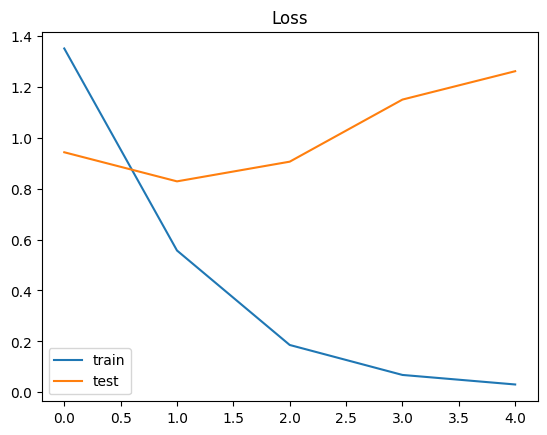

Text(0.5, 1.0, 'Accuracy')

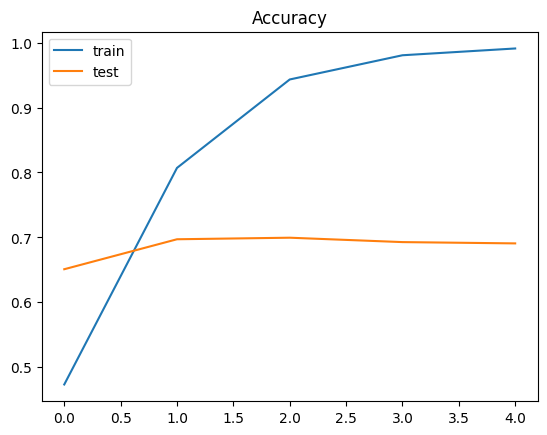

In [14]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [17]:
news_input = input("Enter the news text: ")
news = [news_input]
seq = tokenizer.texts_to_sequences(news)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['world', 'cinema', 'tamilnadu', 'india', 'politics', 'sports']
label = pred, labels[np.argmax(pred)]
print("Primary Tag : "+ label[1])

Enter the news text: ஒலிம்பிக் சாம்பியகின் அபாரமான ஆட்டம் தொடர்கிறது நீரஜ் சோப்ராவின் கிரீடத்தில் மற்றுமொரு மயிலிறகு
1/1 [==============================] - 0s 40ms/step
Primary Tag : sports


In [20]:
probabilities = pred[0]
category_probabilities = zip(labels, probabilities)
sorted_probabilities = sorted(category_probabilities, key=lambda x: x[1], reverse=True)
top_n = 3  # Number of top categories to display
top_categories = sorted_probabilities[:top_n]

print(f"Top {top_n} Predicted Tags:")
for category, probability in top_categories:
    print(f"{category}: {probability:.4f}")

Top 3 Predicted Tags:
sports: 0.5120
cinema: 0.3983
world: 0.0716
